# Sit720 11.1 HD Task

## Part 1 - Reproducing Results From the Prima Dataset

Part 1 of this task involes reproducing the same results for DT, SVM, RF and stacking ensemble. For CV part I don't expect to reproduce exact same results as CV randomly splits data set.

In [3]:
#load relevant libraries 
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

#laod data in
df = pd.read_csv('Diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
#inspect for outliers
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


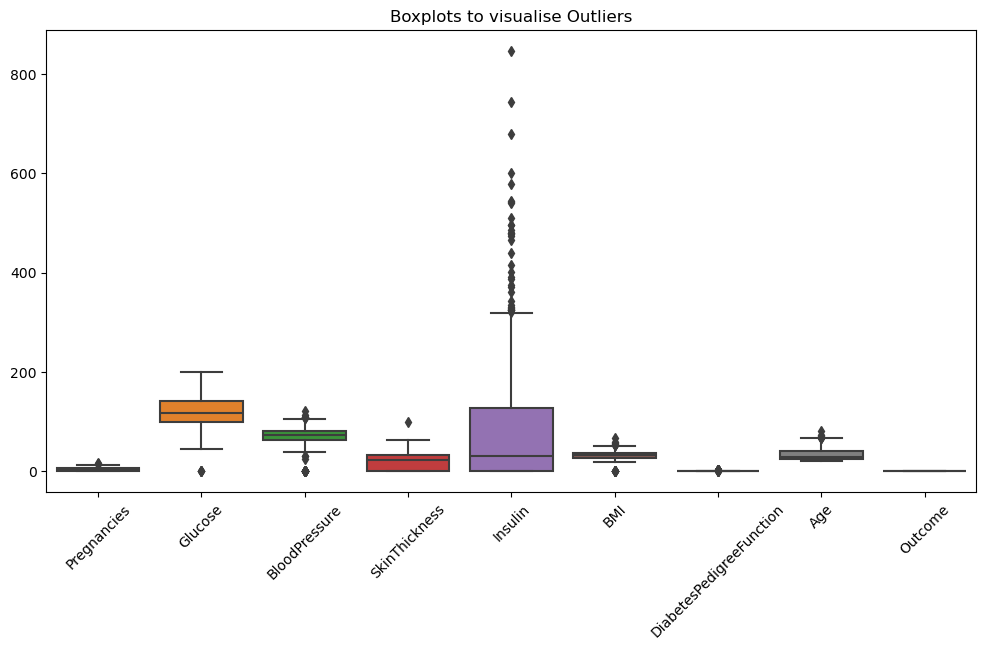

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

#visualise presence of outliers with boxplots
plt.figure(figsize=(12,6))
sns.boxplot(df)
plt.xticks(rotation=45)
plt.title('Boxplots to visualise Outliers');

Article mentions using IQR to identify outliers. Without explicity stating, I will assume the standard formula of Q1- 1.5IQR and Q3+1.5IQR were used to identify outliers.

In [6]:
#find outliers and replace with median for each column
df_no_outcome = df.drop('Outcome',axis=1)

for col in df_no_outcome.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3-q1
    lower_bound = q1 -1.5*IQR
    upper_bound = q3+1.5*IQR
    #replace outliers with median
    df[col]=np.where((df[col]<lower_bound)|(df[col]>upper_bound),df[col].median(),df[col])

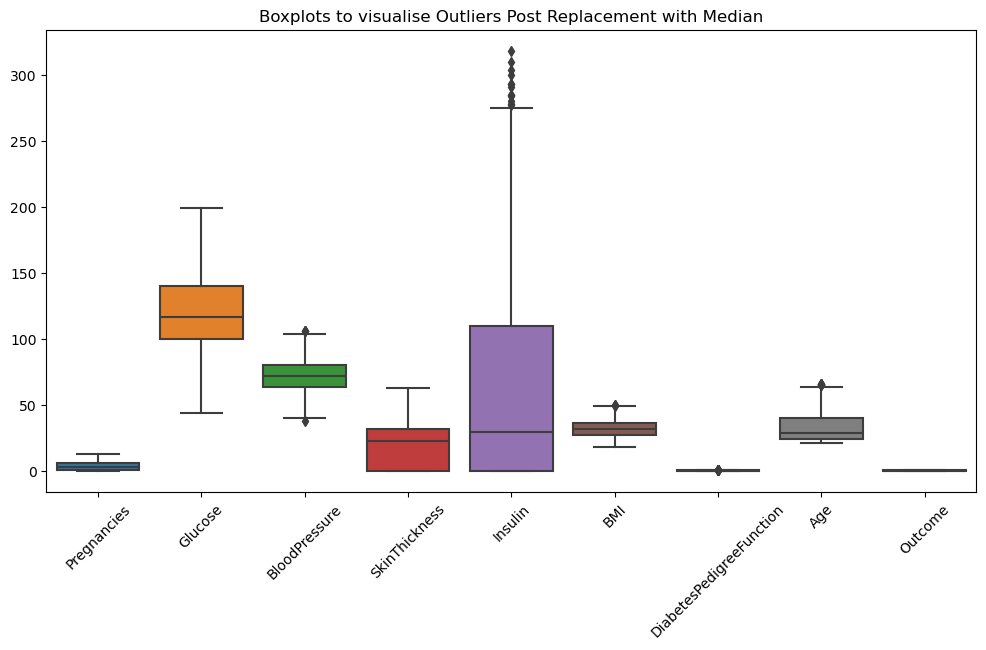

In [7]:
#inspect boxplots too see if outliers have been replaced

#visualise presence of outliers with boxplots after outliers have been replaced
plt.figure(figsize=(12,6))
sns.boxplot(df)
plt.xticks(rotation=45)
plt.title('Boxplots to visualise Outliers Post Replacement with Median');

It appears outliers have been replaced as data does not same outliers. Note even though this new data has outliers, the original data doesn't. The boxplots recalculate values based on transformed data.

In [8]:
#inspect missing values (0 counts as missing for this dataset, except in outcome)

print("Number of 0's in each columns")
for col in df.columns:
    print(f'{col}:{(df[col]==0).sum()}')

Number of 0's in each columns
Pregnancies:111
Glucose:0
BloodPressure:0
SkinThickness:227
Insulin:374
BMI:0
DiabetesPedigreeFunction:0
Age:0
Outcome:500


In [9]:
#besides outcome we replace 0 with the median of that column
#exclude outcome column for the loop
for col in df_no_outcome.columns:
    df[col]=np.where(df[col]==0, df[col].median(),df[col])

In [10]:
#check to see there are no 0s
print("Number of 0's in each columns")
for col in df.columns:
    print(f'{col}:{(df[col]==0).sum()}')

Number of 0's in each columns
Pregnancies:0
Glucose:0
BloodPressure:0
SkinThickness:0
Insulin:0
BMI:0
DiabetesPedigreeFunction:0
Age:0
Outcome:500


All missing entries have been cleaned

In [11]:
#standardise data by first splitting into X and y 
from sklearn.preprocessing import MinMaxScaler

X = df.drop('Outcome',axis=1)
y= df.Outcome

mms = MinMaxScaler()
X_scaled = mms.fit_transform(X)
X_scaled[0:5]

array([[0.41666667, 0.67096774, 0.5       , 0.5       , 0.05180921,
        0.48427673, 0.49326146, 0.64444444],
       [0.        , 0.26451613, 0.41176471, 0.39285714, 0.05180921,
        0.26415094, 0.24528302, 0.22222222],
       [0.58333333, 0.89677419, 0.38235294, 0.28571429, 0.05180921,
        0.16037736, 0.53369272, 0.24444444],
       [0.        , 0.29032258, 0.41176471, 0.28571429, 0.26315789,
        0.31132075, 0.07996406, 0.        ],
       [0.16666667, 0.6       , 0.02941176, 0.5       , 0.50657895,
        0.78301887, 0.26460018, 0.26666667]])

Data has been scaled. Note we split Outcome into y as thats the target variable and does not need to be standardized.

In [12]:
#apply smote to balance class skewness
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#split into 70/30 train/test before applying smote
Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#apply smote on train data to balance classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(Xtrain,ytrain)

### Model 1 Decision Tree

In [11]:
#build Decision tree model using default values since none were given
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report

dtc_clf = DecisionTreeClassifier(random_state=42)

dtc = dtc_clf.fit(X_res, y_res)

#get prediction
dtc_pred = dtc.predict(Xtest)
#get classification report
class_report = classification_report(ytest, dtc_pred)
print(class_report)


              precision    recall  f1-score   support

           0       0.76      0.70      0.73       151
           1       0.51      0.59      0.55        80

    accuracy                           0.66       231
   macro avg       0.64      0.64      0.64       231
weighted avg       0.68      0.66      0.67       231



Values are near identical to whats in study. All differ by 0.01. 

In [12]:
#apply CV = 5
from sklearn.model_selection import cross_val_predict, StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle= True, random_state=42)
y_pred = cross_val_predict(dtc_clf, X_res, y_res, cv=kf, method = 'predict')

class_cv = classification_report(y_res, y_pred)
print(class_cv)

              precision    recall  f1-score   support

           0       0.76      0.74      0.75       349
           1       0.75      0.77      0.76       349

    accuracy                           0.76       698
   macro avg       0.76      0.76      0.75       698
weighted avg       0.76      0.76      0.75       698



### Model 1 Summary  
The study didn't specify method for CV. Also the study didn't specify the hyperparameters for DT and how smote was applied. This meant to be safe I just used default values. The values for accuracy 0.76, precision 0.76, recall 0.74, fl-score 0.75 differ from values in study by 0.08-0.11. This is due to the specific methods used in the study not being explicitly stated. 

### Model 2 Random Forest

In [13]:
#build Random Forest model without cross-validation first
from sklearn.ensemble import RandomForestClassifier 
#intiial rf classifier and fit to X_res, y_res
rf_clf = RandomForestClassifier(random_state=42)
rf = rf_clf.fit(X_res, y_res)

#get prediction
rf_pred = rf.predict(Xtest)
#get classification report
class_report = classification_report(ytest, rf_pred)
print(class_report)


              precision    recall  f1-score   support

           0       0.85      0.78      0.81       151
           1       0.64      0.74      0.69        80

    accuracy                           0.77       231
   macro avg       0.75      0.76      0.75       231
weighted avg       0.78      0.77      0.77       231



In [14]:
#apply CV = 5

kf = StratifiedKFold(n_splits=5, shuffle= True, random_state=42)
y_pred = cross_val_predict(rf_clf, X_res, y_res, cv=kf, method = 'predict')

class_cv = classification_report(y_res, y_pred)
print(class_cv)

              precision    recall  f1-score   support

           0       0.83      0.80      0.81       349
           1       0.80      0.84      0.82       349

    accuracy                           0.82       698
   macro avg       0.82      0.82      0.82       698
weighted avg       0.82      0.82      0.82       698



### Model 2 Summary  
Random Forest values were slighly less than values in the study varying by 0.02-0.05. CV values were slightly higher than the study by 0.03-0.05. These were in respect to accuracy, precision, recall and fl-score.  These differences again are due to the study being very general in how they did these models. The study just states it standarises, uses smote, RF and CV without saying how. Thats four different factors that without the exact details is near impossible to replicate. 

### Model 3 SVM

In [15]:
#build svm model without cross-validation first
from sklearn.svm import SVC 
#intiialise svc and fit to X_res, y_res
svm_clf = SVC(random_state=42, kernel='poly')
svm = svm_clf.fit(X_res, y_res)

#get prediction
svm_pred = svm.predict(Xtest)
#get classification report
class_report = classification_report(ytest, svm_pred)
print(class_report)


              precision    recall  f1-score   support

           0       0.79      0.77      0.78       151
           1       0.59      0.60      0.59        80

    accuracy                           0.71       231
   macro avg       0.69      0.69      0.69       231
weighted avg       0.72      0.71      0.72       231



Using a poly kernel results are near identical to those in study. Only difference is accruacy here is 0.71 vs 0.69 in study. Other scores are same for precision, recall, f1-score.

In [16]:
#apply CV = 5

kf = StratifiedKFold(n_splits=5, shuffle= True, random_state=42)
y_pred = cross_val_predict(svm_clf, X_res, y_res, cv=kf, method = 'predict')

class_cv = classification_report(y_res, y_pred)
print(class_cv)

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       349
           1       0.80      0.77      0.79       349

    accuracy                           0.79       698
   macro avg       0.79      0.79      0.79       698
weighted avg       0.79      0.79      0.79       698



CV scores were 0.1 higher for all scores and 0.07 higher for accuracy. This shows that the CV method I'm using is different to the one used in the study since the base model had near identical results. Again the CV method was never stated, I havejust used a popular method.

### Model 3 Summary  
SVM results were near identical to study, however, the CV results differed by a bit. This again highlights the issue with how the study was lax in specifying the exact procress in which it did each step. 

### Model 4 Stack Ensemble

In [17]:
#build stack ensemble combining the previous 3 models
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

#combine the previous 3 models
estimators = [('dt_clf', DecisionTreeClassifier(random_state=42)),
              ('rf_clf', RandomForestClassifier(random_state=42)),
              ('svm_clf',SVC(random_state=42, kernel='poly'))]

#build Stacking Classifier using logistic regression meta
sc_clf = StackingClassifier(estimators = estimators, final_estimator = LogisticRegression(random_state=42))

sc = sc_clf.fit(X_res, y_res)

#get prediction
sc_pred = sc.predict(Xtest)
#get classification report
class_report = classification_report(ytest, sc_pred)
print(class_report)


              precision    recall  f1-score   support

           0       0.82      0.80      0.81       151
           1       0.64      0.68      0.66        80

    accuracy                           0.76       231
   macro avg       0.73      0.74      0.74       231
weighted avg       0.76      0.76      0.76       231



The stacking classifier got near identical results to the study, off by 0.01 for all and 0.02 for precision. 

In [18]:
#apply CV = 5

kf = StratifiedKFold(n_splits=5, shuffle= True, random_state=42)
y_pred = cross_val_predict(sc_clf, X_res, y_res, cv=kf, method = 'predict')

class_cv = classification_report(y_res, y_pred)
print(class_cv)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       349
           1       0.82      0.82      0.82       349

    accuracy                           0.82       698
   macro avg       0.82      0.82      0.82       698
weighted avg       0.82      0.82      0.82       698



Accuracy was higher by 0.05 and the other measures were higher by 0.1-0.12 than in study.

### Final Summary   
The results in the DT, RF, SVM, and SE were near identical to the ones in the study. The CV differed by a bit. The CV methods I used produced higher results than what was in the study. The main issue was that the study should have been specific in how it performed each step. It was very specific for the neural network methods, stating each parameter used. It was short sighted for DT, RF and SVM. It did not specify the parameters used. Also more importantly, in pre-processing the standardising and smote methods were not stated. These lead to small differences in what I was able to reproduce. The main difference came from how they performed 5-fold cross-validation. I used the popular method of Stratified Kfold and was able to produce much higher results than what the study produced. 

# Part 2 Building my own Model

## Preprocessing

In this section I will build my own model.

In [115]:
#import data again

df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


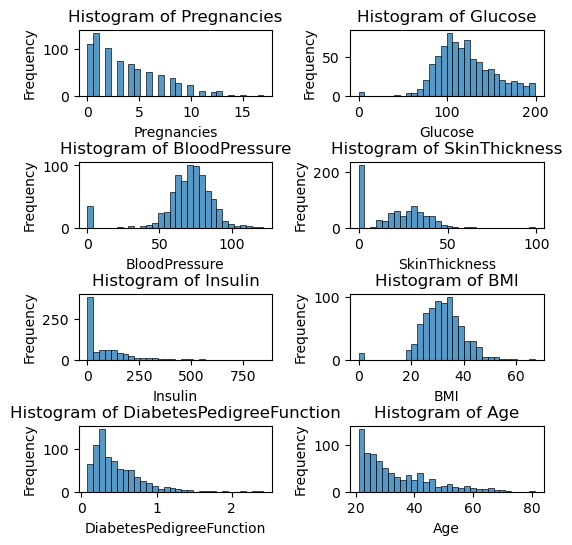

In [116]:
#plot histogram for each column to understand distribution
fig, ax = plt.subplots(4,2, figsize=(6,6))
ax = ax.flatten()

for i in range(df.shape[1]-1):
    sns.histplot(df.iloc[:, i], ax=ax[i], kde=False, bins=30)
    ax[i].set_title(f'Histogram of {df.columns[i]}')
    ax[i].set_xlabel(df.columns[i])
    ax[i].set_ylabel('Frequency')
plt.subplots_adjust(wspace=0.4, hspace=1)


The histograms show most of the data is right skew, some are symmetric. The 0's indicate handling errors in the data as it doesn't make sense. I will handle those first by replacing with median.

In [2]:
#besides outcome we replace 0 with the mean of that column
#exclude outcome column for the loop
df_no_outcome = df.drop('Outcome', axis=1)
for col in df_no_outcome.columns:
    df[col]=np.where(df[col]==0, df[col].mean(),df[col])

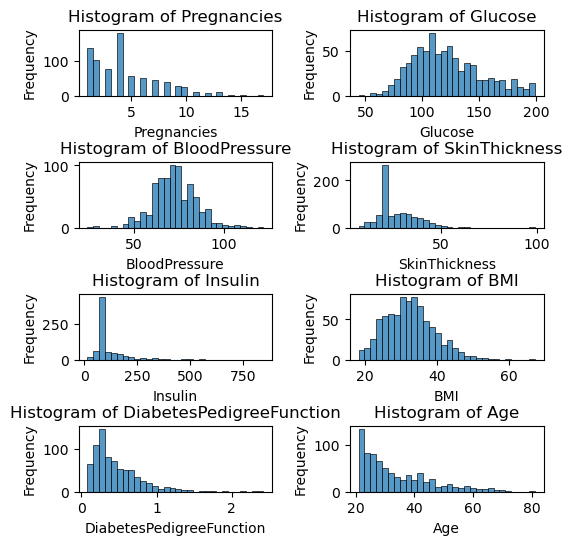

In [118]:
#view distribution after fixing the 0s
fig, ax = plt.subplots(4,2, figsize=(6,6))
ax = ax.flatten()

for i in range(df.shape[1]-1):
    sns.histplot(df.iloc[:, i], ax=ax[i], kde=False, bins=30)
    ax[i].set_title(f'Histogram of {df.columns[i]}')
    ax[i].set_xlabel(df.columns[i])
    ax[i].set_ylabel('Frequency')
plt.subplots_adjust(wspace=0.4, hspace=1)


I won't change outliers to median value as done in the study, instead I will transform data to handle outliers and skewed data.

In [3]:
#Use power-transform to transform data to fix skewness
from sklearn.preprocessing import PowerTransformer

#split data into X and y for features and target

X = df.drop('Outcome',axis=1)
y=df.Outcome
pt = PowerTransformer()
X_scaled = pt.fit_transform(X)

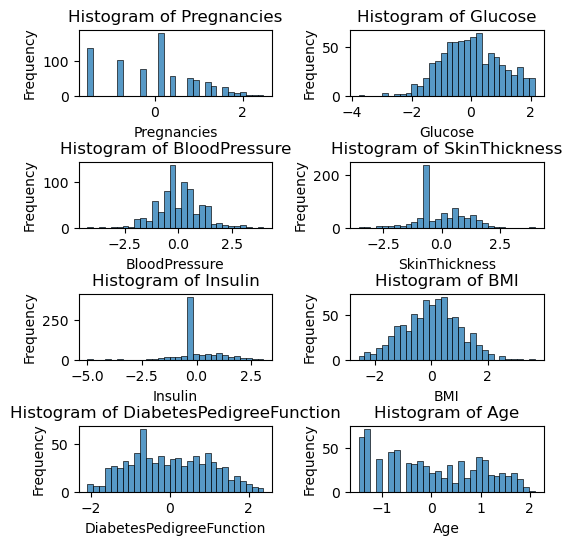

In [120]:
#combine X_scaled and df_no_outcome into df to do histplots
scaled_df= pd.DataFrame(X_scaled, columns = df_no_outcome.columns)\

#view distribution after transforming
fig, ax = plt.subplots(4,2, figsize=(6,6))
ax = ax.flatten()

for i in range(scaled_df.shape[1]):
    sns.histplot(scaled_df.iloc[:, i], ax=ax[i], kde=False, bins=30)
    ax[i].set_title(f'Histogram of {df.columns[i]}')
    ax[i].set_xlabel(df.columns[i])
    ax[i].set_ylabel('Frequency')
plt.subplots_adjust(wspace=0.4, hspace=1)

In [121]:
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled_df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.167277,0.266419,0.066885,0.042150,0.119920,-0.023450,0.568094
Glucose,0.167277,1.000000,0.222366,0.157153,0.416690,0.236683,0.103840,0.266829
BloodPressure,0.266419,0.222366,1.000000,0.141469,0.038548,0.271163,-0.001508,0.347717
SkinThickness,0.066885,0.157153,0.141469,1.000000,0.231704,0.553579,0.113617,0.082683
Insulin,0.042150,0.416690,0.038548,0.231704,1.000000,0.212835,0.134105,0.095561
BMI,0.119920,0.236683,0.271163,0.553579,0.212835,1.000000,0.142497,0.104265
DiabetesPedigreeFunction,-0.023450,0.103840,-0.001508,0.113617,0.134105,0.142497,1.000000,0.046816
Age,0.568094,0.266829,0.347717,0.082683,0.095561,0.104265,0.046816,1.000000


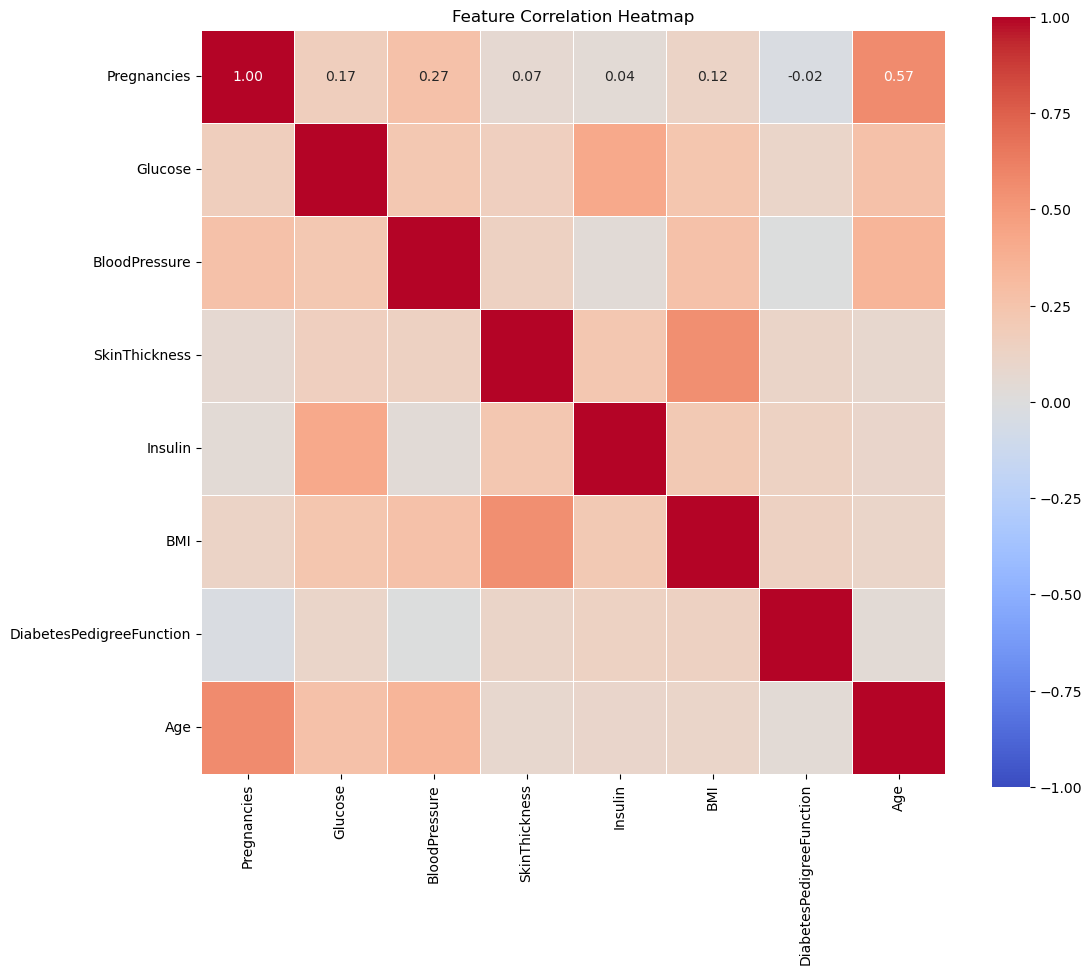

In [122]:
plt.figure(figsize=(12,10))
sns.heatmap(
    X_scaled_df.corr(),
    annot=True,            
    cmap='coolwarm',     
    fmt='.2f',             
    vmin=-1, vmax=1,       
    linewidths=0.5,        
    square=True            
)
plt.title('Feature Correlation Heatmap');

None of the variables are highly correlated so they will all be used. Data looks ready to being modelling.

## Building Model

In [4]:
#use 80/20 split for train/test
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [149]:
#I will now use a GridSearch to find optimal hyperparameters for Random Forest 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#intialise all models for grid search
rf = RandomForestClassifier(random_state=42)

#I will search through multiple values for each parameter
# Define the parameter grid
parameters = {
    'n_estimators': [20, 50, 100,200],
    'criterion':('gini','entropy','log_loss'),
    'max_depth': [5,10,50,100],        
    'max_features': ('sqrt','log2',None)
}
rf_clf = GridSearchCV(rf, parameters)
rf_search = rf_clf.fit(Xtrain,ytrain)

rf_search.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'n_estimators': 100}

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize Random Forest Classifier with optimal parameters
rf_clf = RandomForestClassifier(criterion= 'entropy' ,
                           n_estimators = 100,
                           max_depth = 5,
                           max_features =None ,
                           random_state=42)

# Fit the model
rf = rf_clf.fit(Xtrain, ytrain)

# Make predictions
rf_pred = rf.predict(Xtest)

# Generate and print the classification report
class_report = classification_report(ytest, rf_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#testing if other features perform better than gird search 
rf_clf = RandomForestClassifier(criterion= 'gini' ,
                           n_estimators = 100,
                           max_depth = 50,
                           max_features = None ,
                           random_state=42)

# Fit the model
rf = rf_clf.fit(Xtrain, ytrain)

# Make predictions
rf_pred = rf.predict(Xtest)

# Generate and print the classification report
class_report = classification_report(ytest, rf_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.84      0.81      0.82        99
           1       0.68      0.73      0.70        55

    accuracy                           0.78       154
   macro avg       0.76      0.77      0.76       154
weighted avg       0.78      0.78      0.78       154



On the most optimal method I will find feature importance to see what factors predict diabetes most.

In [141]:
# Best model
rf_clf = RandomForestClassifier(criterion= 'gini' ,
                           n_estimators = 100,
                           max_depth = 50,
                           max_features = None ,
                           random_state=42)

# Fit the model
rf_best = rf_clf.fit(Xtrain, ytrain)

#get feature importances
feat_import = rf_best.feature_importances_

In [142]:
#make a df of feature importance
importances = pd.DataFrame(feat_import, X.columns).reset_index()
importances.columns = ['Feature','Importance']
importances = importances.sort_values('Importance', ascending=False)
importances.head()

,Feature,Importance
1,Glucose,0.329093
5,BMI,0.158353
7,Age,0.130122
6,DiabetesPedigreeFunction,0.120241
2,BloodPressure,0.080432


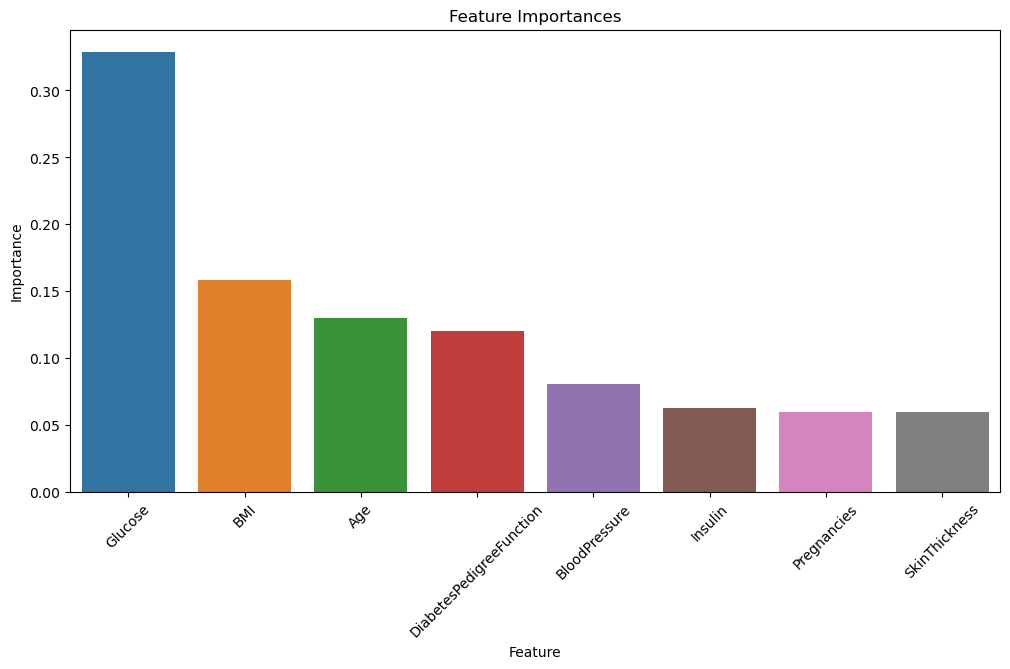

In [143]:
#plot features
plt.figure(figsize=(12,6))
sns.barplot(x='Feature',y='Importance', data=importances)
plt.xticks(rotation=45)
plt.title('Feature Importances');

Top feature contributing to diabetes is glucose, followed by BMI and Age. Glucose is by far the biggest importance.